<div align="center">

# **Online Retail Recommendation System**  
### Internship Major Project 1

---

### Submitted by: **Rajath H M**
### Domain: **Data Science**

</div>

# ✅ Step 1: Import Required Libraries

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
import os

# Setup directories
os.makedirs("output", exist_ok=True)
os.makedirs("visuals", exist_ok=True)

# 📥 Step 2: Load Dataset

In [17]:
data = pd.read_excel("data/OnlineRetail.xlsx", engine="openpyxl")
print("Initial shape:", data.shape)

Initial shape: (541909, 8)


# 🧹 Step 3: Data Cleaning

In [18]:
data = data.dropna(subset=['CustomerID'])
data = data[data['Quantity'] > 0]
data = data[~data['InvoiceNo'].astype(str).str.startswith('C')]
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['Description'] = data['Description'].str.strip().str.upper()
data.drop_duplicates(inplace=True)
print("Cleaned shape:", data.shape)

Cleaned shape: (392732, 8)


# 📊 Step 4: Data Description & EDA

# Global Top 10 Products

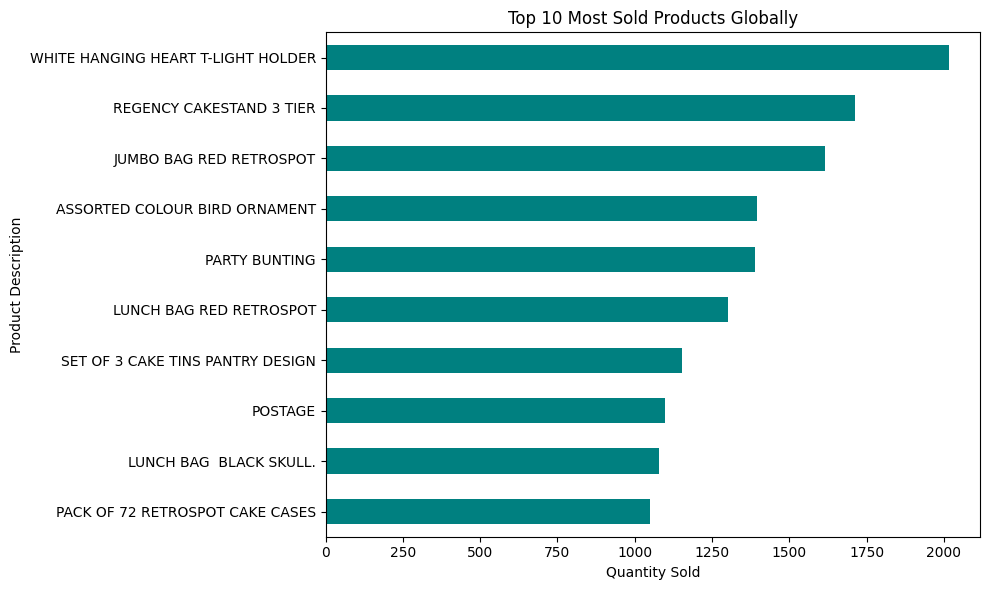

In [19]:
top_products = data['Description'].value_counts().head(10)
plt.figure(figsize=(10,6))
top_products.plot(kind='barh', color='teal')
plt.title("Top 10 Most Sold Products Globally")
plt.xlabel("Quantity Sold")
plt.ylabel("Product Description")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("visuals/top_10_products.png")
plt.show()

# Country-wise Top Sales

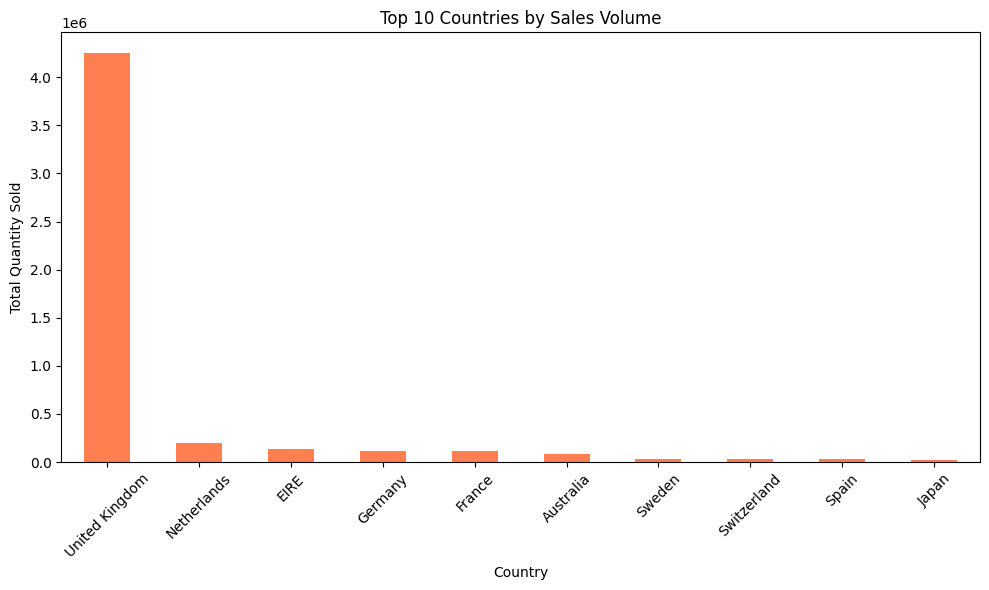

In [20]:
country_sales = data.groupby('Country')['Quantity'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,6))
country_sales.plot(kind='bar', color='coral')
plt.title("Top 10 Countries by Sales Volume")
plt.ylabel("Total Quantity Sold")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("visuals/sales_by_country.png")
plt.show()

# Month-wise Sales

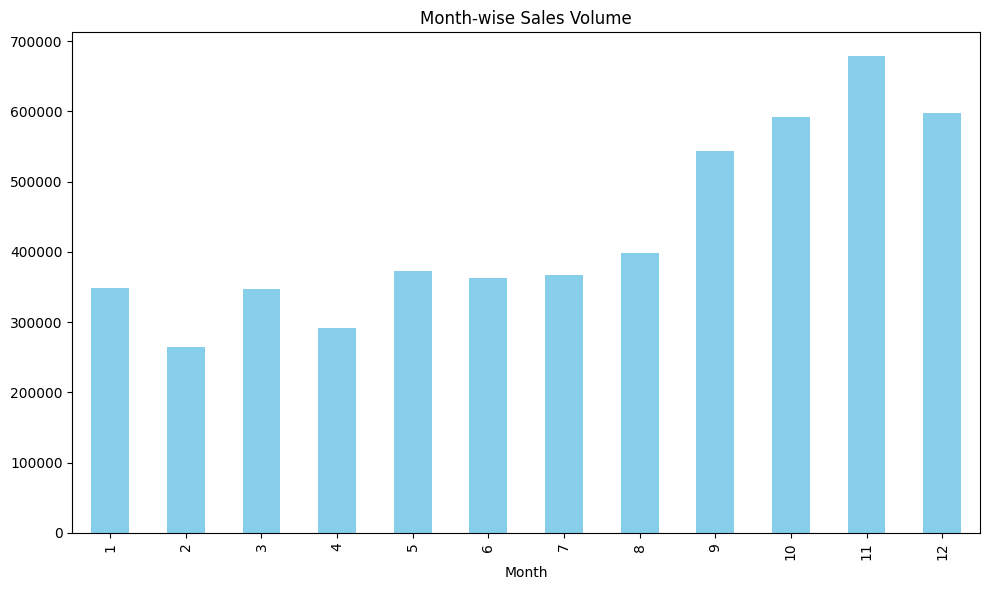

In [21]:
data['Month'] = data['InvoiceDate'].dt.month
month_sales = data.groupby('Month')['Quantity'].sum()
plt.figure(figsize=(10,6))
month_sales.plot(kind='bar', color='skyblue')
plt.title("Month-wise Sales Volume")
plt.xlabel("Month")
plt.tight_layout()
plt.savefig("visuals/monthwise_sales.png")
plt.show()

# 🔎 Step 5: Popular Item Finder Functions

In [22]:
def get_popular_items(df, by='global'):
    if by == 'global':
        return df['Description'].value_counts().head(10)
    elif by == 'country':
        return df.groupby('Country')['Description'].value_counts().groupby(level=0).head(1)
    elif by == 'month':
        return df.groupby('Month')['Description'].value_counts().groupby(level=0).head(1)
    else:
        return "Invalid option"

print("Popular Items Globally:")
print(get_popular_items(data, by='global'))

print("\nPopular Items Country-wise:")
print(get_popular_items(data, by='country'))

print("\nPopular Items Month-wise:")
print(get_popular_items(data, by='month'))

Popular Items Globally:
Description
WHITE HANGING HEART T-LIGHT HOLDER    2016
REGENCY CAKESTAND 3 TIER              1714
JUMBO BAG RED RETROSPOT               1615
ASSORTED COLOUR BIRD ORNAMENT         1395
PARTY BUNTING                         1390
LUNCH BAG RED RETROSPOT               1303
SET OF 3 CAKE TINS PANTRY DESIGN      1152
POSTAGE                               1099
LUNCH BAG  BLACK SKULL.               1078
PACK OF 72 RETROSPOT CAKE CASES       1050
Name: count, dtype: int64

Popular Items Country-wise:
Country               Description                        
Australia             RED TOADSTOOL LED NIGHT LIGHT             9
Austria               POSTAGE                                  14
Bahrain               NOVELTY BISCUITS CAKE STAND 3 TIER        2
Belgium               POSTAGE                                  96
Brazil                CLOCK MAGNET MUM'S KITCHEN                1
Canada                COLOURING PENCILS BROWN TUBE              3
Channel Islands       DOO

# 🧠 Step 6: Item-Based Collaborative Filtering

In [23]:
pivot_table = data.pivot_table(index='CustomerID', columns='Description', values='Quantity', aggfunc='sum').fillna(0)
item_sim = cosine_similarity(pivot_table.T)
item_sim_df = pd.DataFrame(item_sim, index=pivot_table.columns, columns=pivot_table.columns)

def recommend_item(product_name, num=5):
    if product_name in item_sim_df:
        return item_sim_df[product_name].sort_values(ascending=False)[1:num+1]
    else:
        return "Product not found."

item_sim_df.to_csv("output/item_similarity_matrix.csv")

# 🧠 Step 7: Content-Based Filtering using TF-IDF

In [24]:
unique_desc = data.drop_duplicates(subset='Description')
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(unique_desc['Description'])

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
tfidf_sim_df = pd.DataFrame(cosine_sim, index=unique_desc['Description'], columns=unique_desc['Description'])

def recommend_content(product_name, num=5):
    if product_name in tfidf_sim_df:
        return tfidf_sim_df[product_name].sort_values(ascending=False)[1:num+1]
    else:
        return "Product not found."

tfidf_sim_df.to_csv("output/content_similarity_matrix.csv")

# 🧠 Step 8: Latent Factor Model (SVD)

In [25]:
X = pivot_table.T
X_scaled = StandardScaler().fit_transform(X)

svd = TruncatedSVD(n_components=20)
latent_matrix = svd.fit_transform(X_scaled)
latent_df = pd.DataFrame(latent_matrix, index=X.index)

latent_sim = cosine_similarity(latent_df)
latent_sim_df = pd.DataFrame(latent_sim, index=X.index, columns=X.index)

def recommend_latent(product_name, num=5):
    if product_name in latent_sim_df:
        return latent_sim_df[product_name].sort_values(ascending=False)[1:num+1]
    else:
        return "Product not found."

latent_sim_df.to_csv("output/latent_similarity_matrix.csv")

# ✅ Step 9: Sample Recommendations

In [26]:
sample_products = top_products.index[:5]
recommendations = {}

for prod in sample_products:
    recommendations[prod] = {
        'Item-Based': recommend_item(prod).to_dict(),
        'Content-Based': recommend_content(prod).to_dict(),
        'Latent': recommend_latent(prod).to_dict()
    }

rec_df = pd.DataFrame.from_dict(recommendations, orient='index')
rec_df.to_csv("output/sample_recommendations.csv")
rec_df


,Item-Based,Content-Based,Latent
WHITE HANGING HEART T-LIGHT HOLDER,{'GIN + TONIC DIET METAL SIGN': 0.750191984126...,{'PINK HANGING HEART T-LIGHT HOLDER': 0.833716...,{'RED HANGING HEART T-LIGHT HOLDER': 0.9836889...
REGENCY CAKESTAND 3 TIER,{'MINI PLAYING CARDS FUN FAIR': 0.700902073237...,{'SWEETHEART CAKESTAND 3 TIER': 0.741599545139...,{'REGENCY TEA PLATE ROSES': 0.9919247198633644...
JUMBO BAG RED RETROSPOT,"{'JUMBO BAG STRAWBERRY': 0.9006224915874825, '...",{'VINTAGE DOILY JUMBO BAG RED': 0.646908355527...,{'JUMBO BAG BAROQUE BLACK WHITE': 0.976544526...
ASSORTED COLOUR BIRD ORNAMENT,"{'IVORY DINER WALL CLOCK': 0.8656053312439107,...",{'ASSORTED COLOUR T-LIGHT HOLDER': 0.462383887...,{'PAINTED METAL PEARS ASSORTED': 0.97731622251...
PARTY BUNTING,"{'SPOTTY BUNTING': 0.42642046722956395, 'JUMBO...",{'PAPER BUNTING VINTAGE PARTY': 0.802473428604...,"{'POTTING SHED TEA MUG': 0.8733689577319105, '..."
